# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

<br>
## Beta Version for Hurricane Matthew


<br>

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from scipy.integrate import simps

#import pydotplus
from IPython import display
from IPython.display import Image
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("RdBu", n_colors=32)
from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy import stats
from scipy.stats import gaussian_kde as PDF

import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

**---**

## Open a datasets

<br>

### 1- Hurricane Matthew Data

<br>

In [2]:
# Open data sets:
# --------------

# Data dictionary
data_dic = {}

# specify date columns
date_range = [[0,1,2,3,4]]

# Open the data files
for i in range(5):
    file_name = 'datasets/data_' + str(i+1) + '.txt'
    inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                              parse_dates = date_range , infer_datetime_format = True)
    data_dic['df_' + str(i + 1)] = inter.iloc[:,1:]

# Sanity check    
data_dic['df_1'].head(10)

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,104,7.9,9.5,99.00,99.00,99.00,999,1012.8,27.9,28.4,26.0,99.0,99.0
1,103,7.6,9.8,99.00,99.00,99.00,999,1013.0,28.2,28.4,26.6,99.0,99.0
2,102,8.9,11.0,99.00,99.00,99.00,999,1013.1,28.2,28.4,26.4,99.0,99.0
3,105,8.5,10.3,99.00,99.00,99.00,999,1013.2,28.3,28.3,26.3,99.0,99.0
4,105,8.6,10.2,1.54,6.67,5.03,89,1013.4,28.2,28.3,25.9,99.0,99.0
5,104,7.7,9.6,99.00,99.00,99.00,999,1013.3,28.3,28.3,26.3,99.0,99.0
6,102,8.2,9.9,99.00,99.00,99.00,999,1013.4,28.3,28.4,26.4,99.0,99.0
7,101,8.8,10.8,99.00,99.00,99.00,999,1013.4,28.3,28.3,26.4,99.0,99.0
8,100,8.4,10.2,99.00,99.00,99.00,999,1013.8,28.3,28.3,26.5,99.0,99.0
9,101,8.4,10.2,99.00,99.00,99.00,999,1013.8,28.3,28.3,26.5,99.0,99.0


In [3]:
# Concatenate all files:
# ---------------------

# initiation
df_global_raw = data_dic['df_1']

# concatente

title = ['WSPD' , 'GST' , 'PRES' , 'ATMP']
# title = ['WDIR' , 'WSPD' , 'GST' , 'PRES' , 'ATMP' , 'DEWP']

for i in range(2,6):
    df_global_raw = pd.concat([df_global_raw , data_dic['df_' + str(i)]] , axis = 0)
    
df_global = df_global_raw[title]

# data array
data_raw = df_global.values

In [4]:
# Preprocessing
# -------------

# determine defected rows
defect = []

# itterrate
for i in range (data_raw.shape[0]):
    if data_raw[i,-1] > 200.:
        defect.append(i)

# remove rows
data_clean = np.delete(data_raw, defect, axis = 0)

### 1- Simulated Data (White Noise)

<br>

In [5]:
# simulated Data
# --------------

d1 = np.random.normal(0. , 0.5 , (3000 , 2))
d2 = np.random.normal(0. , 0.9 , (500 , 2))
d3 = np.random.normal(0. , 0.5 , (3000 , 2))

sim_data1 = np.concatenate((d1, d2) , axis = 0)
sim_data = np.concatenate((sim_data1 , d3), axis = 0)

## General Functions

<br>

### 1- Power Martingale with defined Epsilon

<br>

In [6]:
# Function to calculate Power Martingale - Single:
# ----------------------------------------------

def power_martingale(data , eps , delay, sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # initiate difference measure
    diff_arr = np.zeros((L,))
    
    # Initiate difference multiplier
    diff = 1.

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        # diff_arr[i] = np.log( np.absolute(diff * (delta - 1.)) )
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

In [7]:
# Function to calculate Power Martingale - array:
# ----------------------------------------------

def power_martingale_arr(data , eps , delay):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.0000000001
    
    # size of epsilons
    n_eps = eps.shape[0]
    
    # reshape the epsilons
    eps_r = eps.reshape((1,n_eps))
    
    # initiate Power Martingale
    power_mart = np.zeros((L , n_eps))

    # dummy multiplier
    M = np.zeros(eps_r.shape)
    
    # initiate difference measure
    diff_arr = np.zeros((L , n_eps))
    
    # Initiate difference multiplier
    diff = np.ones((L , n_eps))

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        diff_arr[i] = np.absolute(np.log(delta))
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

### 2- Power Martingale with Mixture

<br>

In [8]:
# Function to calculate Power Martingale:
# ---------------------------------------

def power_martingale_mix(data , res , delay, sim = False):
    
    # Normalization
    data_norm = data / np.std(data, axis = 0)
    
    # initiate Filtered data
    d = np.zeros(data_norm.shape)
    
    # delay-Filter
    for i in range (delay, data_norm.shape[0]):
        d[i, :] = data_norm[i,:] - data_norm[ i - delay , : ]
        
    if(sim):
        d = data

    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        np.random.seed(200)
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
        # p_value[i] = float(np.sum(alpha_sub >= end))  / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)
    
    # initiate difference
    diff_arr = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.

    # iterrate for power martingale calculation
    for i in range(L):
    
        # Calculate delta Array    
        delta = np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Integrate for mix
        delta_mix = simps(delta , eps)
        
        # update power martingale
        M += delta_mix
        
        # Array
        power_mart[i] = M
        
        # difference
        diff_arr[i] = np.absolute(delta_mix)
        
        
    return power_mart , diff_arr

### 3- Support Functions

<br>

In [9]:
# Exponential Smoother:
# ---------------------

def smooth(y , alpha):
    
    # initiation of the filtered signal array
    x = np.zeros(y.shape)
    
    # Data size
    L = y.shape[0]
    
    # intiation
    x[0] = 0.5 * (1. + alpha) * y[0]
    
    # Iterrate for new samples
    for i in range(1,L):
        x[i] = alpha * y[i] + (1. - alpha) * x[i - 1]
        
    return x

In [10]:
# Function to generate a heatmap array for raw and smoothed signal
# ----------------------------------------------------------------

def heatmap_fil(x , alpha):
    
    # signal length
    L = x.shape[0]
    
    # apply smoothing
    xk = smooth(x , alpha)
    
    # reshape arrays
    x1 = xk.reshape((1,L)) / np.max(xk)
    x2 = x.reshape((1,L)) / np.max(x)
    
    # Augment arrays
    big1 = np.concatenate((x1 , x1) , axis = 0)
    big2 = np.concatenate((x2 , x2) , axis = 0)
    
    # Join arrays
    big = np.concatenate((big1 , big2) , axis = 0)
    
    return big
        


## Model Tuning

<br>

### 1- Constants

<br>

In [11]:
# Selected epsilon array
e_array = np.linspace(0.01,0.99,100)

# selected delay array
delay_array = np.array(range(1,501))

# Dimensions
rows = len(delay_array)
cols = len(e_array)

# Resolution for mixture integral
resolution = 200

# Smoothing factor for change detection
a = 0.008

# Data size
L = data_clean.shape[0]

# Color map 
clr = plt.get_cmap('jet')

### 2- Power Martingale with variable Epsilon

<br>

In [12]:
# Tune for e and delay:
#----------------------

# Initiation of measure array
measure_pwr = np.zeros((rows, cols))

# timer initiation
timer_1 = 0.

for i in range(rows):
    
    # start timer
    start_1 = time.time()
    
    # specify delay
    de = int(delay_array[i])
        
    # specify epsilon
    e = e_array
    display.clear_output(wait=True)
    display.display('processing step ' + str(i + 1) + ' for delay ' + str(de), 
                    'Process time for previous step : ' + str(timer_1) + ' sec')
        
    # evaluate the difference
    pmar, dif = power_martingale_arr(data_clean, e , de)
    dif_s = smooth(dif , a)
        
    # maximum at Matthew
    dif_max_m = np.max(dif_s[17000:18000] , axis = 0)
        
    # Put in measure array
    measure_pwr[i] = (dif_max_m - np.average(dif_s , axis = 0)) / dif_s.std(axis=0)
        
    # timer end
    timer_1 = time.time() - start_1

##                   

'processing step 500 for delay 500'

'Process time for previous step : 5.6859998703 sec'

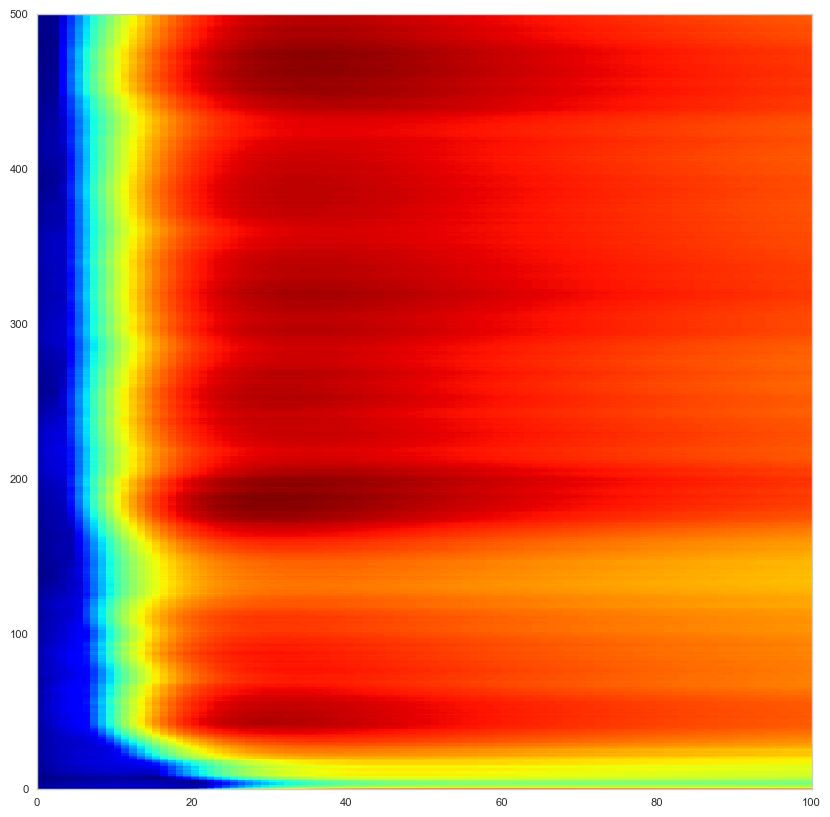

In [13]:
# Viisualize Tunning results:
# ---------------------------

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.pcolor(measure_pwr , cmap = clr)

plt.show()

In [14]:
# Best Values
# -----------

best_row = int(np.argmax(measure_pwr) / cols)
best_col = np.argmax(measure_pwr) - best_row * cols

best_de_pwr = int(delay_array[best_row])
best_e_pwr  = e_array[best_col]

print '\nBest Delay is : ' , best_de_pwr
print 'Best Epsilon Value is : ' , best_e_pwr


Best Delay is :  189
Best Epsilon Value is :  0.30696969697


In [15]:
# Application and Visualization(Power Martingale)
# ----------------------------------------------

# simulated data 
p_mar1_pwr , diff1_pwr = power_martingale(sim_data,best_e_pwr , best_de_pwr , sim = True)

# Filtered data
p_mar2_pwr, diff2_pwr = power_martingale(data_clean,best_e_pwr , best_de_pwr)

##

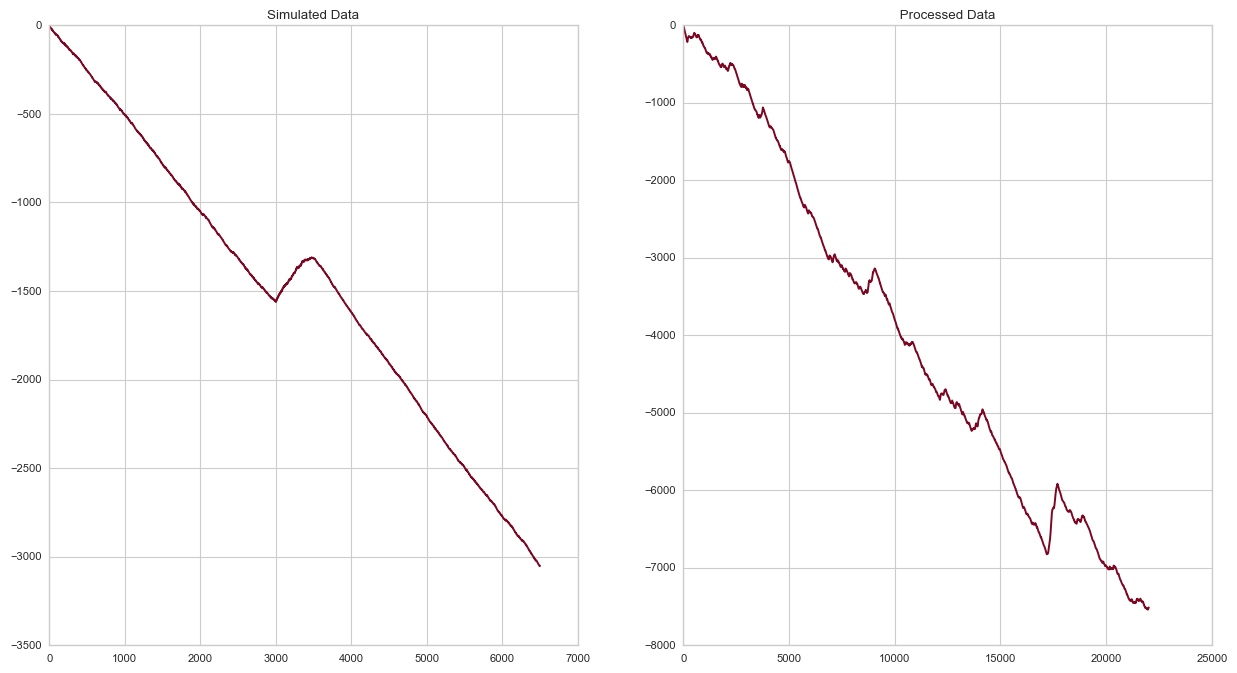

In [16]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,8))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_pwr)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2_pwr)
ax2.set_title(' Processed Data ')

plt.show()

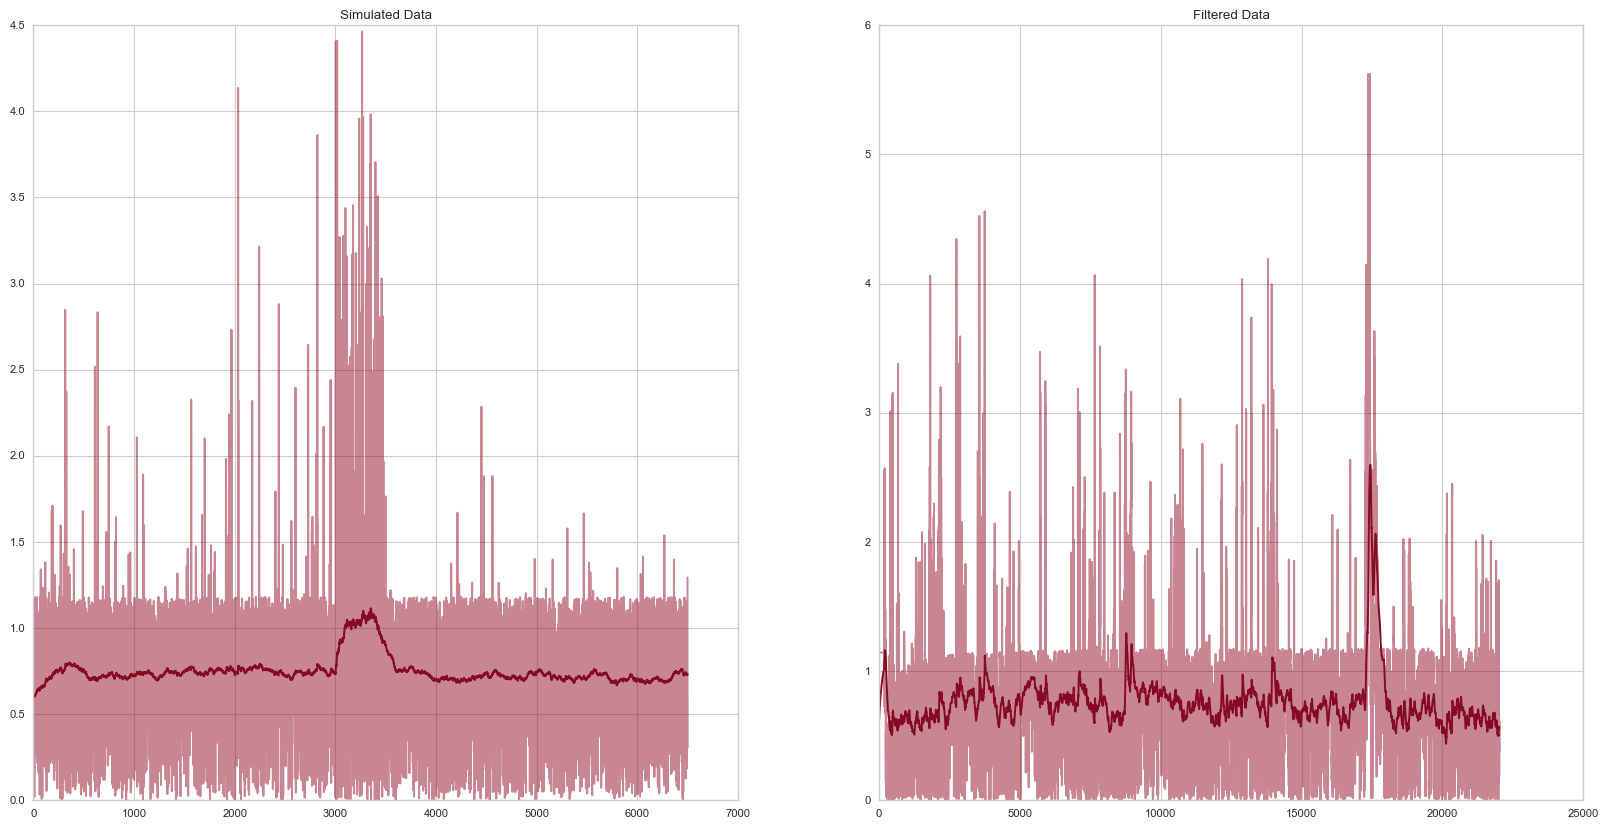

In [17]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,10))

# Simulated Data
ax1 = fig.add_subplot(121)
ax1.plot(smooth(diff1_pwr , a))
ax1.plot(diff1_pwr , alpha = 0.5)
ax1.set_title('Simulated Data')

# Processed data data
ax2 = fig.add_subplot(122)
ax2.plot(smooth(diff2_pwr , a) )
ax2.plot(diff2_pwr , alpha = 0.5)
ax2.set_title('Filtered Data')

plt.show()

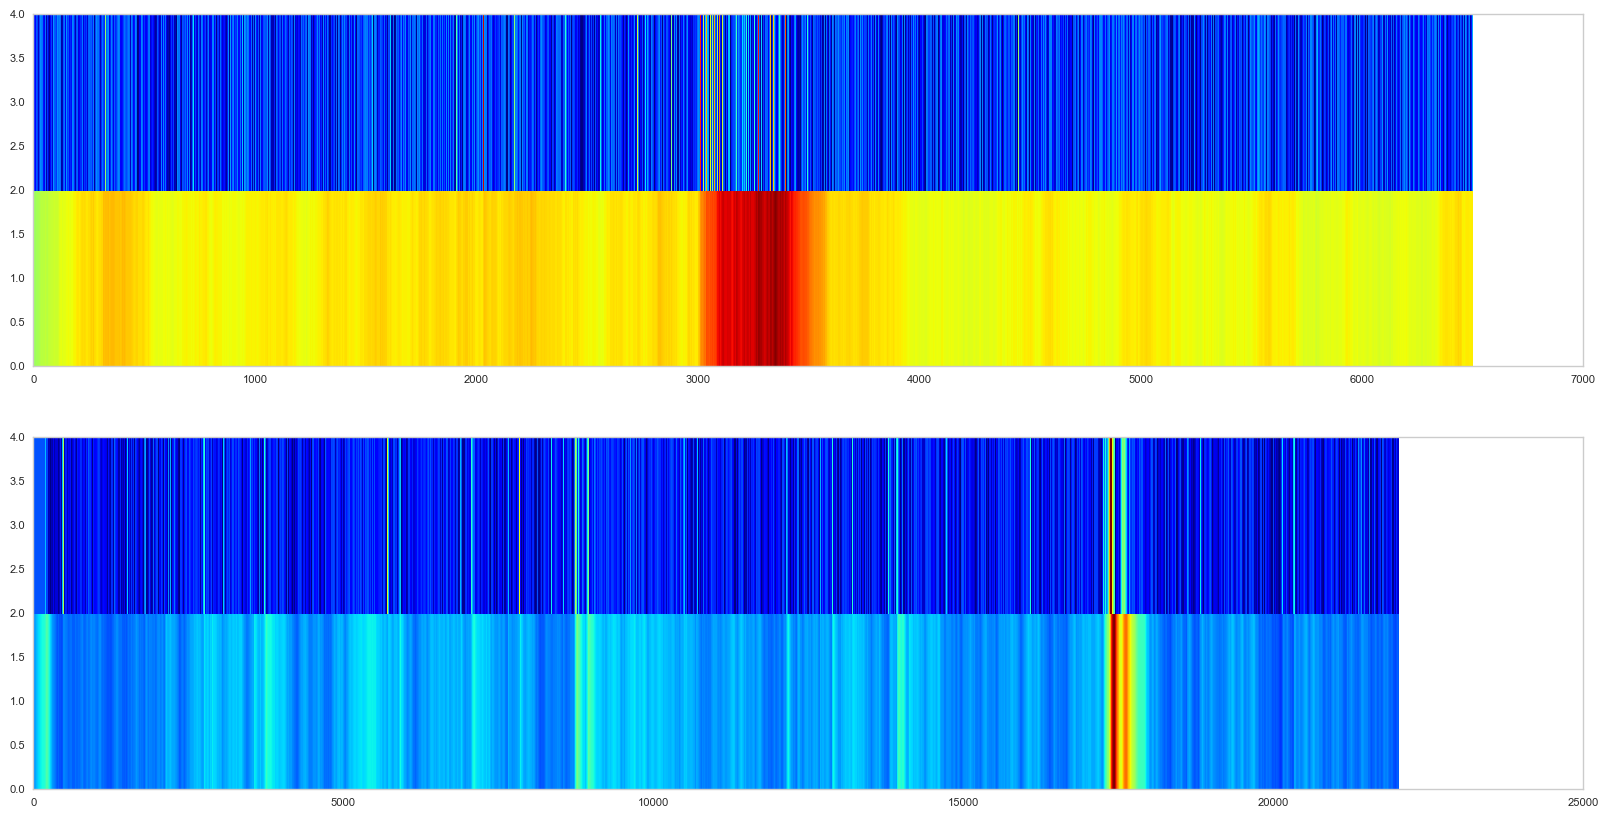

In [ ]:
# visualize the heatmaps:
# -----------------------

fig = plt.figure(figsize = (20,10))

#
ht1_pwr = heatmap_fil(diff1_pwr , a)
ax1 = fig.add_subplot(2,1,1)
ax1.pcolor(ht1_pwr , cmap = clr)

#
ht2_pwr = heatmap_fil(diff2_pwr , a)
ax2 = fig.add_subplot(2,1,2)
ax2.pcolor(ht2_pwr , cmap = clr)

plt.show()

### 2- Power Martingale with Mixture

<br>

In [ ]:
# Tune for delay:
#----------------

# Initiation of measure array
measure_mix = np.zeros((rows,))

# timer initiation
timer_2 = 0.

for i in range(rows):
    
    # start timer
    start_2 = time.time()
    
    # specify delsy
    de = int(delay_array[i])
    
    # display progress
    display.clear_output(wait=True)
    display.display('Processing delay of ' + str(de) + ' at step ' + str(i + 1), 
                    'Process time : ' + str(timer_2) + ' sec')
        
    # evaluate the difference
    pmar, dif = power_martingale_mix(data_clean, resolution , de)
    dif_s = smooth(dif , a)
    
        
    # maximum data Matthew
    dif_max_m = np.max(dif_s[17000:18000])
    
        
    # Put in measure array
    measure_mix[i] = (dif_max_m - np.average(dif_s)) / dif_s.std(axis=0)
    
    # stop timer
    timer_2 = time.time() - start_2


                   

'Processing delay of 10 at step 10'

'Process time : 9.65299987793 sec'

In [ ]:
# Viisualize Tunning results:
# ---------------------------

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(111)
ax.plot(measure_mix)

plt.show()

In [ ]:
# Best Values
# -----------

best_de_mix = int(delay_array[np.argmax(measure_mix)])

print '\nBest Delay is : ' , best_de_mix

In [ ]:
# Application and Visualization (Power Martingale with Mixture)
# -------------------------------------------------------------

# simulated data 
p_mar1_mix , diff1_mix = power_martingale_mix(sim_data,resolution , best_de_mix , sim = True)

# Filtered data
p_mar2_mix, diff2_mix = power_martingale_mix(data_clean,resolution , best_de_mix)

##

In [ ]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,8))

# plot simulated data
ax1 = fig.add_subplot(1,2,1)
ax1.plot(p_mar1_mix)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(1,2,2)
ax2.plot(p_mar2_mix)
ax2.set_title(' Processed Data ')

plt.show()

In [ ]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,10))

# Simulated Data
ax1 = fig.add_subplot(121)
ax1.plot(smooth(diff1_mix , a))
ax1.plot(diff1_mix , alpha = 0.5)
ax1.set_title('Simulated Data')

# Processed data data
ax2 = fig.add_subplot(122)
ax2.plot(smooth(diff2_mix , a) )
ax2.plot(diff2_mix , alpha = 0.5)
ax2.set_title('Filtered Data')

plt.show()

In [ ]:
# visualize the heatmaps:
# -----------------------

fig = plt.figure(figsize = (20,10))

#
ht1_mix = heatmap_fil(diff1_mix , a)
ax1 = fig.add_subplot(2,1,1)
ax1.pcolor(ht1_mix , cmap = clr)

#
ht2_mix = heatmap_fil(diff2_mix , a)
ax2 = fig.add_subplot(2,1,2)
ax2.pcolor(ht2_mix , cmap = clr)

plt.show()

---